# SQLite database and euiprep
Since release 5.0, we provide an SQLite database containing all the meta-data of all the FITS files in the data release. This database is very powerful in that it allows you to quickly get an idea of data coverage, and also search for a particular set of images without restrictions.

In this part of the tutorial we will show you how you can work with these SQLite databases. The database is available locally under ./data_sqlite/

[metadata_L1](https://www.sidc.be/EUI/data/L1/metadata_L1.db)
[metadata_L2](https://www.sidc.be/EUI/data/L2/metadata_L2.db)

## SQLite - EUI Data Availability
We are using the sqlite3 package to work with the sqlite databases, and will gather data in a pandas frame and also play around with datetime and delta times, so let's import those first.

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

It's time to the database, and create a cursor we can use to execute sql queries with. This is very similar to using for example the psycopg2 python package to work with PostgreSQL databases.

In [4]:
con = sqlite3.connect('data_sqlite/metadata_L1.db')
cur = con.cursor()

The databases have just the one table called fits_file. Let's look at the columns of that table..

In [5]:
res = cur.execute("SELECT count(*) FROM fits_file")
for row in res:
    print(row)

res = cur.execute("SELECT * FROM fits_file")
names = list(map(lambda x: x[0], res.description))

(181874,)


In [145]:
names


['id',
 'insertion_time',
 'filepath',
 'filename',
 'comment',
 'history',
 'simple',
 'bitpix',
 'naxis',
 'naxis1',
 'naxis2',
 'pcount',
 'gcount',
 'xtension',
 'bscale',
 'bzero',
 'longstrn',
 'date',
 'file_raw',
 'parent',
 'apid',
 'date-obs',
 'date-beg',
 'date-avg',
 'timesys',
 'obt_beg',
 'level',
 'origin',
 'creator',
 'vers_sw',
 'version',
 'imgtype',
 'jobid',
 'complete',
 'obsrvtry',
 'telescop',
 'instrume',
 'detector',
 'doorint',
 'doorext',
 'xposure',
 'filter',
 'filtpos',
 'wavelnth',
 'wavemin',
 'wavemax',
 'soopname',
 'sooptype',
 'obs_mode',
 'obs_type',
 'obs_id',
 'target',
 'btype',
 'bunit',
 'ucd',
 'blank',
 'pxbeg1',
 'pxend1',
 'pxbeg2',
 'pxend2',
 'nbin1',
 'nbin2',
 'nbin',
 'wcsname',
 'ctype1',
 'ctype2',
 'cunit1',
 'cunit2',
 'pc1_1',
 'pc1_2',
 'pc2_1',
 'pc2_2',
 'cdelt1',
 'cdelt2',
 'crota',
 'crval1',
 'crval2',
 'crpix1',
 'crpix2',
 'lonpole',
 'att_skd',
 'detgainl',
 'detgainh',
 'gaincomb',
 'readoutm',
 'downloam',
 'gainthre

Good. We potentially have lots of information in this table, in fact it contains all the meta-data that is in every single FITS file that was part of the release, including the history of those files. All this data is available at our fingertips and easily searchable. 

To find out what all these keywords mean, there are a few reference documents that explain all the EUI FITS keywords. These documents can be found at the [Archive Support Data confluence page](https://issues.cosmos.esa.int/solarorbiterwiki/display/SOSP/Archive+Support+Data#ArchiveSupportData-Understandingthedata.1)


Let's now see if we can get some idea on the EUI data availability.

In [6]:
df = pd.DataFrame(columns=['date','wavelnth','nbin','combitpp','offset1', 'offset2','crota'])

def dailyImageCount(cur, detector):
    counts = dict()
    res = cur.execute("SELECT \"date-beg\",detector FROM fits_file WHERE detector=? ORDER BY \"date-beg\" ASC", [detector])

    for row in res:
        dts = datetime.strptime(row[0], '%Y-%m-%dT%H:%M:%S.%f')
        day = datetime(dts.year, dts.month, dts.day)
        if day not in counts:
            counts[day] = 1
        else:
            counts[day] += 1

    return counts
    
counts_fsi = dailyImageCount(cur, detector='FSI')
print("We counted {} days of FSI images".format(len(counts_fsi)))

We counted 227 days of FSI images


We now have the counts of all FSI images of the Sun (IMGTYPE == 'solar image') per day. Let's turn this into a nice plot to create an overview of which days  the telescope was taking Solar images.

<IPython.core.display.Javascript object>


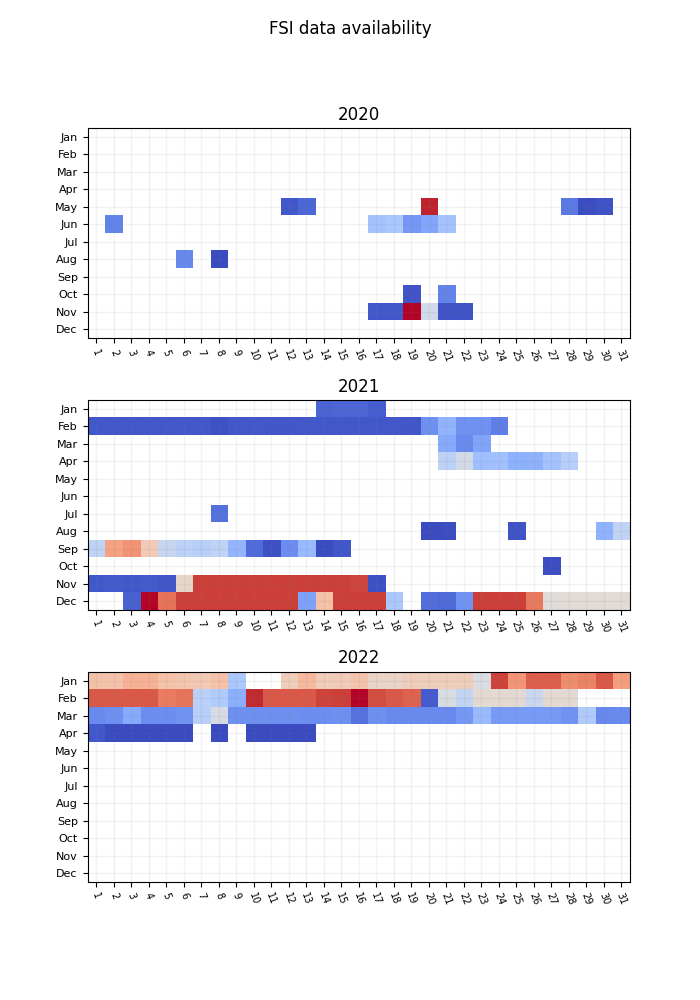

In [7]:

def heatmap(counts, title):
    m = np.zeros((12, 31))
    m[:] = np.nan

    sortedkeys = sorted(counts)
    max_year = np.max(sortedkeys).year
    min_year = np.min(sortedkeys).year
    fig, axes = plt.subplots(nrows=1+(max_year - min_year), ncols=1, figsize=(7, 10))
    fig.suptitle(title)

    for year in range(min_year,max_year+1):
        m[:] = np.nan
        for key in sortedkeys:
            if key.year == year:
                m[key.month-1, key.day-1] = counts[key]

        s=year-min_year
        axes[s].grid(color='gray', linestyle='-', linewidth=1, alpha=0.1)
        axes[s].imshow(m, cmap='coolwarm', interpolation='nearest')
        axes[s].set_title(year)
        plt.sca(axes[s])
        plt.xticks(np.arange(31), np.arange(31)+1, rotation=-70, fontsize=7)
        plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec'], fontsize=8)
        
    plt.show()
    
heatmap(counts_fsi, title='FSI data availability')



We have been taking FSI synoptic pretty much non-stop since December last year. Let's get some results also for HRI LYA and HRI EUV.

<IPython.core.display.Javascript object>


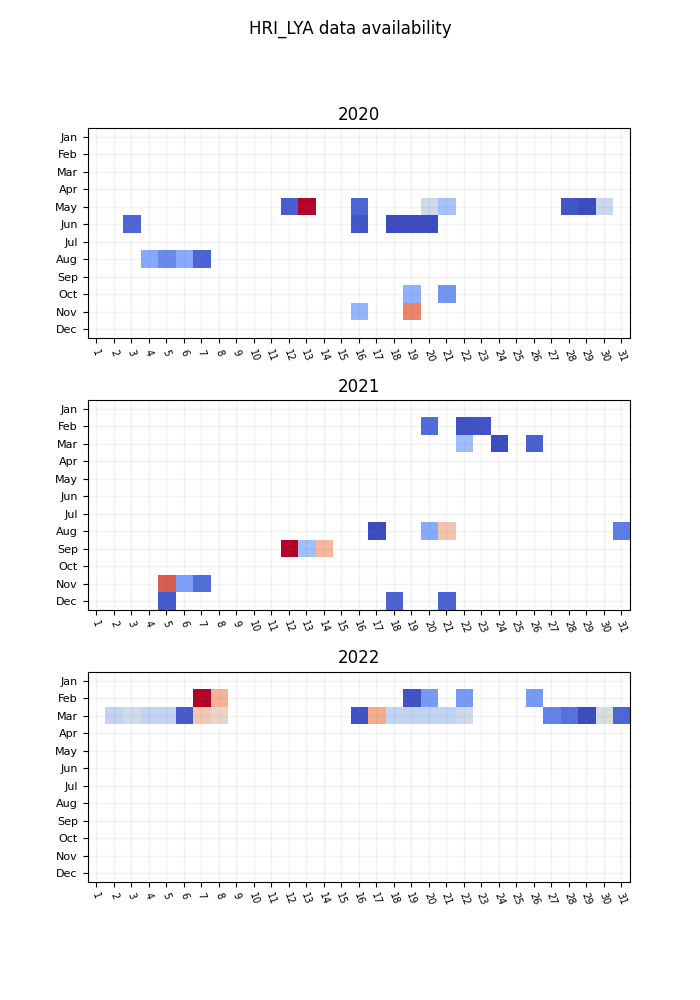

In [8]:
heatmap(dailyImageCount(cur, detector='HRI_LYA'), title='HRI_LYA data availability')

<IPython.core.display.Javascript object>


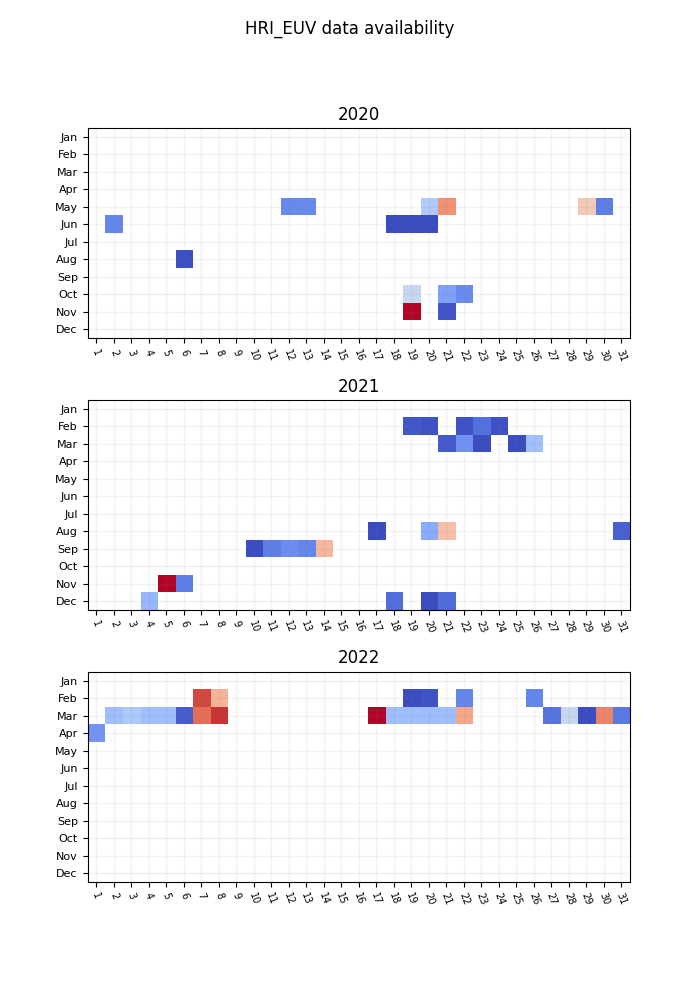

In [9]:
heatmap(dailyImageCount(cur, detector='HRI_EUV'), title='HRI_EUV data availability')

As you can see, we take FSI data much more regularly. We actually try to image with FSI almost all the time, even outside of remote sensing windows. But the HRI_EUV and HRI_LYA telescopes are only operated during remote sensing windows, and then we tend to operate these telescopes in bursts of 30 minutes up to maybe a few hours in length.

## FSI pointing meta-data and Limb-fitting
In this part of the tutorial we'll have a look at the pointing meta-data in FSI files, and how this information is updated in the L2 files when using euiprep. We'll be using a few L1 and L2 files, and, again, the SQLite metadata files.


In [10]:
conL1 = sqlite3.connect('data_sqlite/metadata_L1.db')
curL1 = conL1.cursor()

conL2 = sqlite3.connect('data_sqlite/metadata_L2.db')
curL2 = conL2.cursor()

Let's go over the L2 FSI files we took in 2022 to see the results of the limb-fitting procedure in euiprep as compared to the raw pointing information that is available in the L1 files. We query the L2 database for the PARENT and CRVALn values, and filter on the 174 wavelength and files that were not binned (NBIN=1). Furthermore, we filter on those L2 files whose pointing information was successfully updated with euiprep, indicating by a "Pointing updated" notification in the HISTORY keywords.

In [11]:

def createDataFramePointingFSI(wavelength):
    prev_dts = None
    df = pd.DataFrame(columns=['date','wavelnth','nbin','combitpp','offset1', 'offset2','crota'])
    res = curL2.execute("SELECT parent,filename,crval1,crval2, \"date-beg\",wavelnth, nbin, combitpp, crota FROM fits_file WHERE \"date-beg\">'2022-01-01 00:00:00' and detector='FSI' and wavelnth=? and nbin=1 and (history like '%Pointing updated%') ORDER BY \"date-beg\" ASC LIMIT 100000", [wavelength])
    for row in res:
        parent          = row[0]
        crval1,crval2   = row[2],row[3]
        datebeg         = row[4]
        wavelnth        = row[5]
        nbin            = row[6]
        combitpp        = row[7]
        crota           = row[8]

        dts = datetime.strptime(datebeg, '%Y-%m-%dT%H:%M:%S.%f')
        if (prev_dts is None) or (dts >= (prev_dts + timedelta(hours=1))):
            prev_dts = dts

            resL1 = curL1.execute("SELECT crval1,crval2 FROM fits_file WHERE filename=? LIMIT 1", [parent])
            for r in resL1:
                ocrval1,ocrval2 = r[0],r[1]
                offset1         = ocrval1-crval1
                offset2         = ocrval2-crval2
                entry = pd.DataFrame.from_dict({'date':[datebeg], 'wavelnth':[wavelnth], 'nbin':[nbin], 'combitpp':[combitpp],'offset1':[offset1], 'offset2':[offset2],'crota':[crota]})
                df = pd.concat([df,entry], ignore_index=True)
    
    # We convert the date column to pandas datetime, and set this as the index column.
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%dT%H:%M:%S.%f")
    df = df.set_index('date')
    return df



We will use our fancy function to look at all the FSI174 images.

In [12]:
df = createDataFramePointingFSI(174)

Now let's plot the results.


<IPython.core.display.Javascript object>


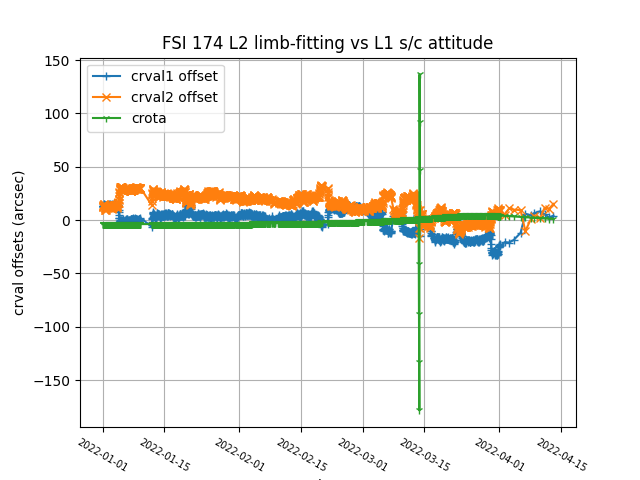

In [13]:
def plotPointing(df):
    plt.close('all')
    plt.plot(df["offset1"], marker='+', label='crval1 offset')
    plt.plot(df["offset2"], marker='x', label='crval2 offset')
    plt.plot(df["crota"],  marker='1', label='crota')
    plt.legend(loc="upper left")
    plt.xticks(rotation=-30, fontsize=7)

    plt.xlabel("date")
    plt.ylabel("crval offsets (arcsec)")
    plt.title("FSI {} L2 limb-fitting vs L1 s/c attitude".format(df["wavelnth"][-1]))
    plt.grid()

    plt.show()
    
plotPointing(df)

Interesting. For FSI 174 images, we can see a discrepancy between the L1 pointing information, and the L2 pointing information. Is this also the case for FSI 304 images??

<IPython.core.display.Javascript object>


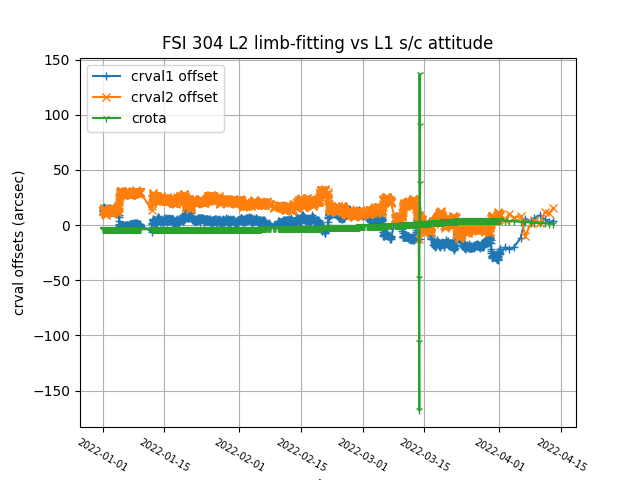

In [14]:
df = createDataFramePointingFSI(304)
plotPointing(df)

Good, that plot looks extremely similar. It seems the effect is both in 174 and 304 images. The EUI FSI pointing is changing over time, and over short periods of time. There are slow trends visible of about 20 arc seconds over months of time, but there are also changes of 15-25 arc seconds that occur in just an hour or two. There are even smaller and regular oscillations visible over the period of 30-40 minutes. 

We are still investigating these inaccuracies in detail, but it seems to be caused at least partially by thermoelastic effects as there appears to be a correlation between the temperature of the EUI Central Electronic Box (CEB) and in particular the fast changes in pointing from L1 to L2. 

This likely affects the HRI EUV and HRI LYA telescopes in a similar way. Unfortunately, for HRI EUV and HRI LYA the pointing information is not updated when creating the L2 files, and this wrong pointing information - based on the spacecraft pointing - is simply copied from L1 to L2. With a pixel scale of approximately 0.5 arc seconds for HRI EUV and 1.0 for HRI LYA (binned 2x2), this translates to an error of aproximately 30-50 pixels in HRI EUV and 15-30 pixels in LYA.

#### Help?

If you have ideas or would like to help correcting the pointing information in particular for the HRI telescopes, please let us know. Until then, please be advised that the pointing information for the HRI telescopes is not accurate in L2 files; sequences will appear to be relatively stable over short periods of time, but even then there are small oscillations visible that were not captured by the space craft pointing and were thus likely caused by thermo-elastic effects as well. 

Now let's see if we can actually see this misalignment in FSI data.

In [18]:
import sunpy.map
import astropy.units as u
from astropy.coordinates import SkyCoord

map_l1 = sunpy.map.Map('data_fsi\solo_L1_eui-fsi304-image_20220401T060015166_V01.fits')
map_l2 = sunpy.map.Map('data_fsi\solo_L2_eui-fsi304-image_20220401T060015166_V01.fits')

<IPython.core.display.Javascript object>


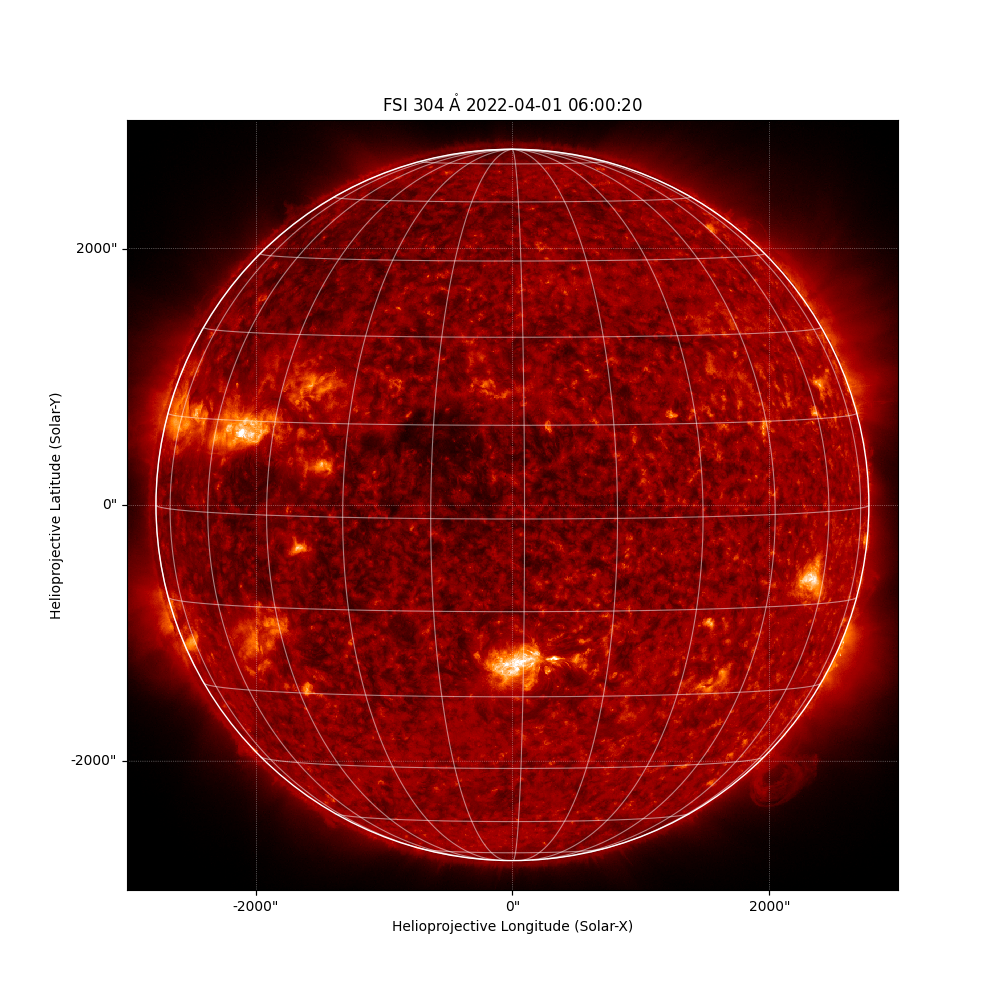

In [19]:
plt.rcParams["figure.figsize"] = (10, 10)

def showMap(amap, rotate=True, arcsec=3000):
    m = amap
    if rotate:
        m = m.rotate()
        
    if arcsec is not None:
        top_right = SkyCoord(arcsec * u.arcsec, arcsec * u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-arcsec * u.arcsec, -arcsec * u.arcsec, frame=m.coordinate_frame)
        m = m.submap(bottom_left, top_right=top_right)

    plt.figure()
    m.plot(clip_interval=(1, 99.99)*u.percent)
    m.draw_limb()
    m.draw_grid()
    plt.show()
    
showMap(map_l1)

It's not that obvious, but the pointing information in the L1 file is indeed off by about 20 arc seconds for this image, this is most notable in the east-wester direction. When looking at the L2 file, we should see that limb-fitting will correct this nicely:

<IPython.core.display.Javascript object>


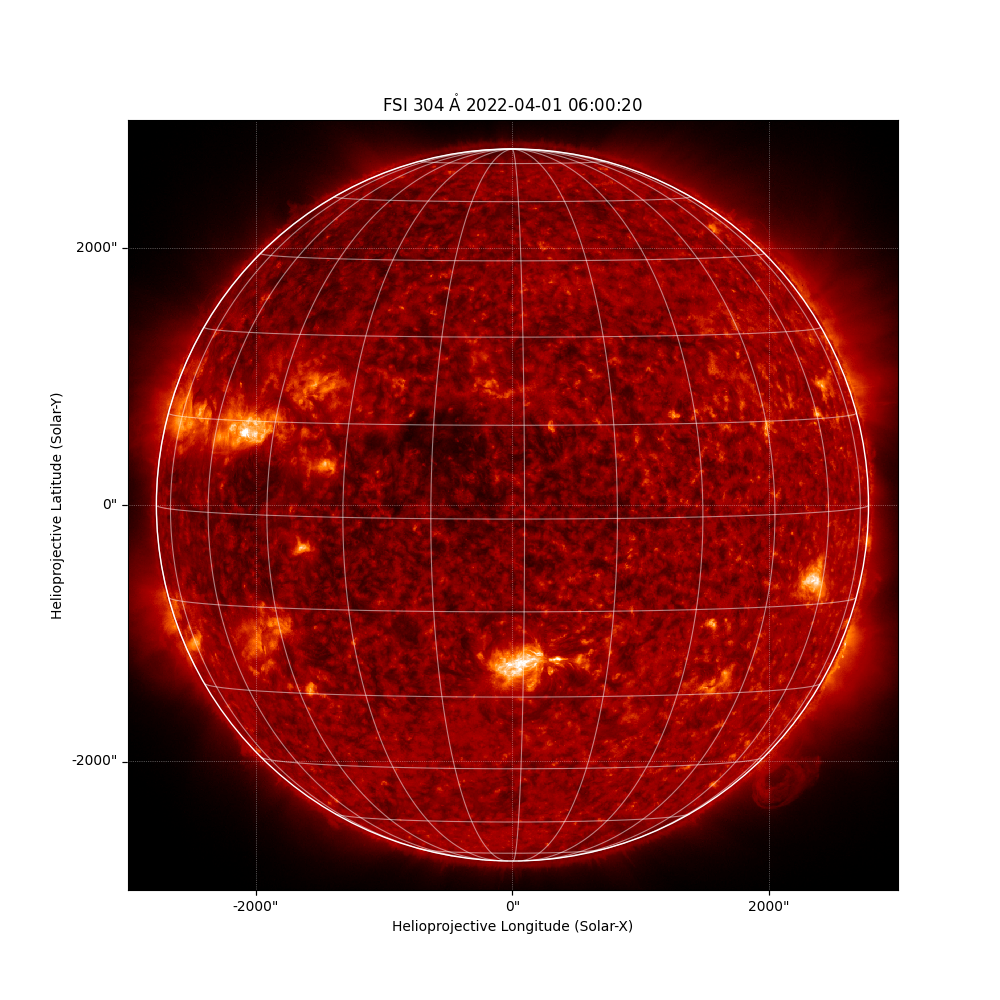

In [20]:
showMap(map_l2)

And luckily it does! 


## Using euiprep
Previously, we plotted the L2 file with SunPy and rotated the image north-up and made a crop around the solar center. Sunpy can do this because it knows about the WCS keywords inside the fits file that tell it where the Sun is in the image. However, euiprep by default - and the EUI L2 data in the data releases as an extension of that - does not move the Sun to the center of the image, nor does it rotate north-up, but instead it adapts the PCi_j and CRVALn keywords. 

We can however force euiprep to rotate north-up, so let's have a look at that. First a reminder of what the L1 and L2 image looks like. 

<IPython.core.display.Javascript object>


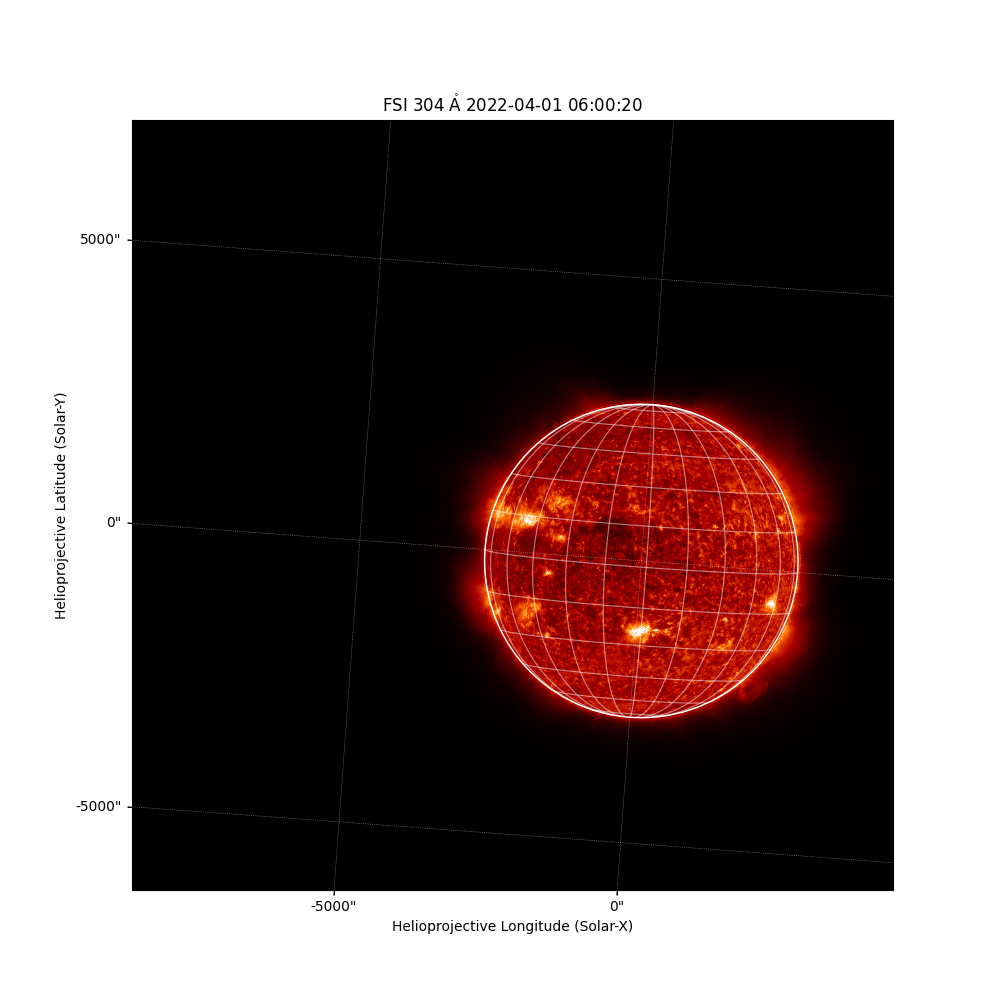

In [21]:
showMap(map_l2, rotate=False, arcsec=None)

It's off-pointed, and the Sun is not with north-up (euiprep did however correct FSI images for known optical distortions).

OK. Let us import soloEUI package, and see which version we have.

In [22]:
import soloEUI
soloEUI.__version__

ModuleNotFoundError: No module named 'soloEUI'

We're using version 5.1 of euiprep. This is the version that was used for data release 5.

When using L2 files for a new data release, euiprep is used in 'auto' mode (auto=True). Here we are overwriting some options, to make sure we center the image and place north up.

In [291]:
euimap_L2 = soloEUI.euiprep("./data_fsi/solo_L1_eui-fsi304-image_20220401T060015166_V01.fits", geometric_rectifications={'optical':True, 'center':True, 'north_up':True}, darkframe_correction=False, save_L2=True)

This should have created an L2 FITS file for us. If a FITS file with the same new already existed, it will increase the version number and create a new L2 FTIS file instead. Let's see the name of the L2 file it created.

In [292]:
euimap_L2.last_L2_filename


'solo_L2_eui-fsi304-image_20220401T060015166_V02.fits'

.. and open this file in SunPy to see what it looks like compared to the previous L2 file

<IPython.core.display.Javascript object>


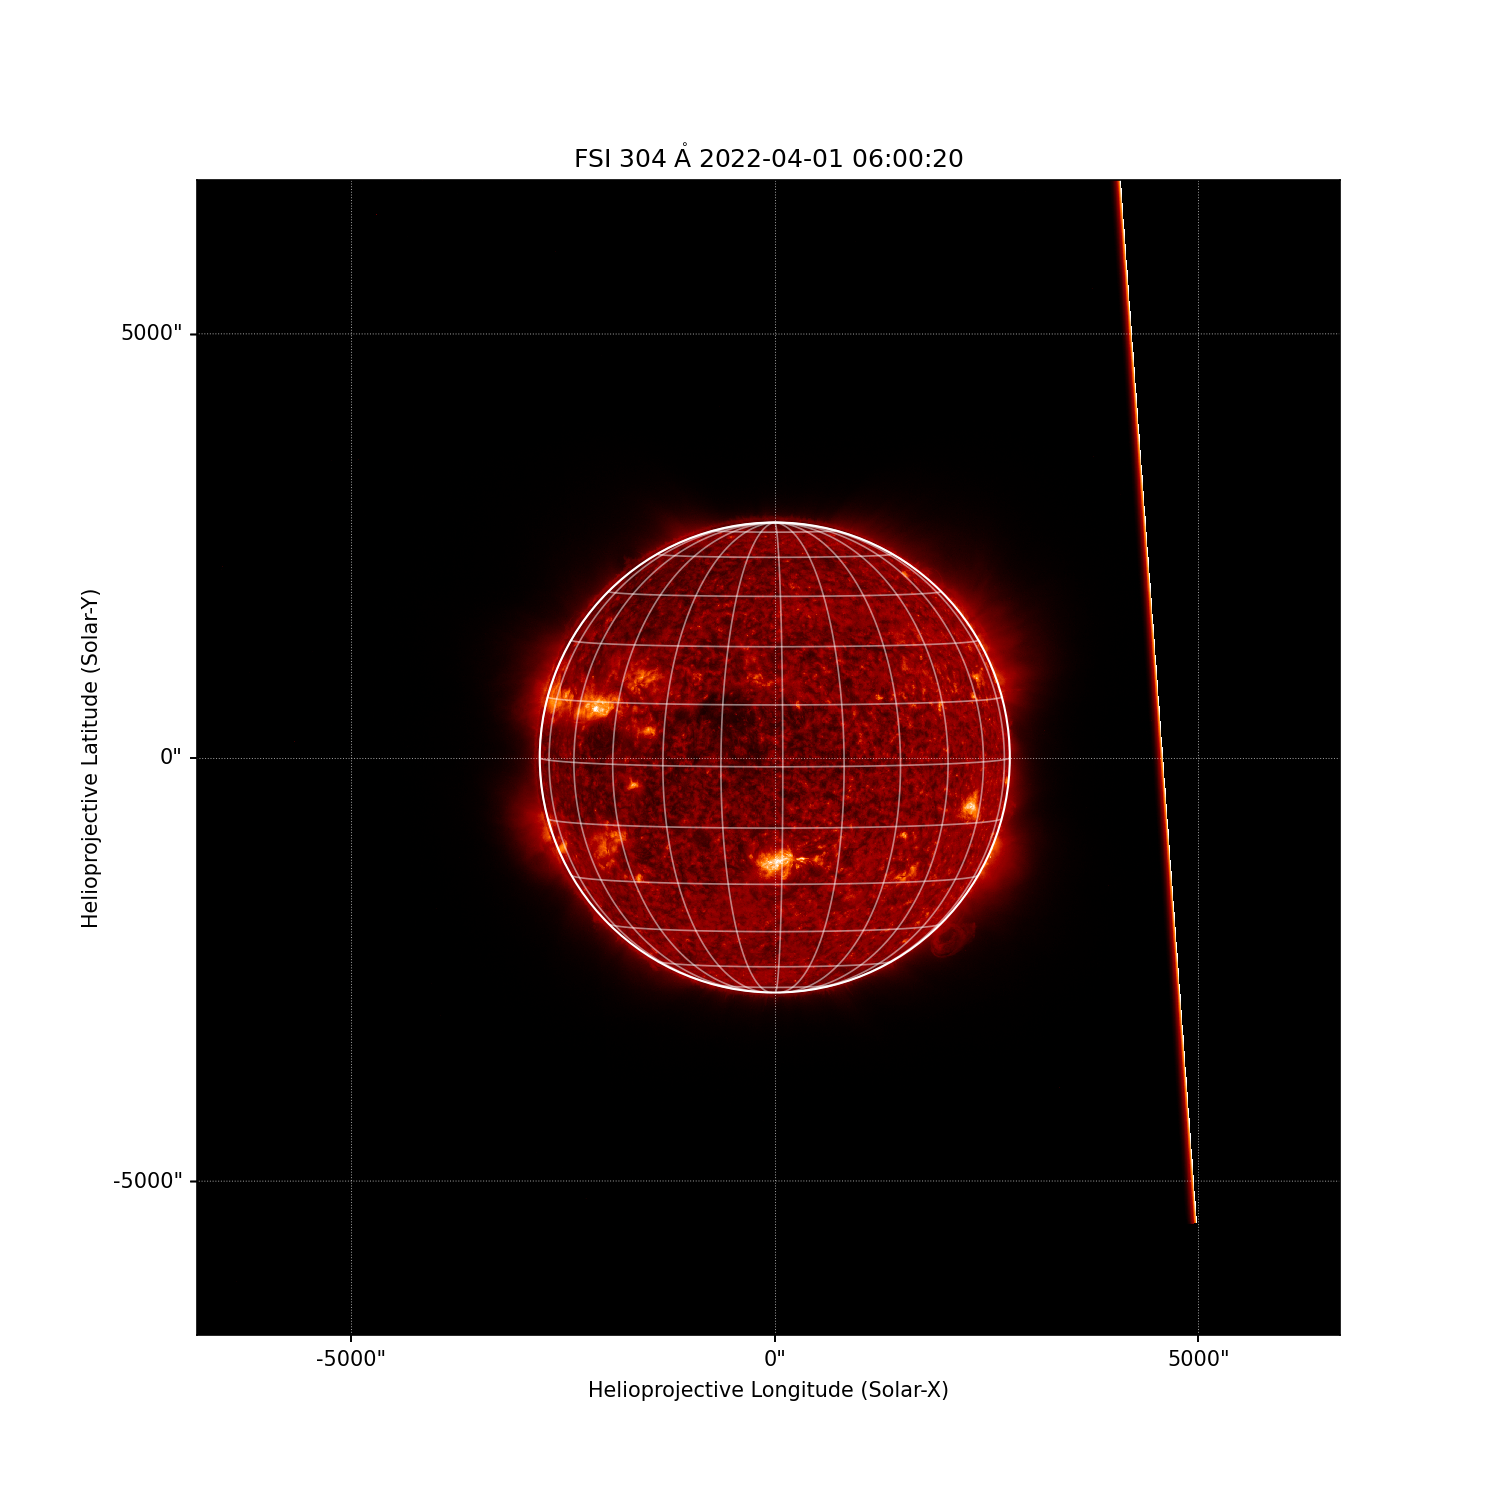

In [293]:
map_l2_new = sunpy.map.Map(euimap_L2.last_L2_filename)
showMap(map_l2_new, rotate=False, arcsec=None)

It placed the Sun in the center, and placed north up! This translation came at the cost of now missing pixels in the left corner, and as we don't like to throw data away, that is one of the main reasons we chose not to apply centering the images and placing north up when creating L2 files.

We can also see a bright line at the right side of the image; this is a detector artifact visible in L1 files that by default gets removed by euiprep. Unfortunately, there is currently a bug in the euiprep software in that it does not remove the bright lines correctly when the image was centered or had north placed up.

Either way, this exercise was more to show that you don't actually need L2 files with the Sun centered and north placed up; the information is available in the current L2 FITS files, and (smart) existing software knows how to use the information!

'5.1'

### Comparing FSI, HRI EUV, HRI LYA, with AIA data
As we have seen before, the pointing information that is currently available in the L1 FITS files (and in L2 for HRI EUV and HRI LYA) is changing over time, depending on temperature changes that are currently not fully understood. 

For FSI data this is 'fixed' in L2 by limb-fitting the images. That procedure is very robust (it works for essentially all FSI images that show the Sun) and is accurate on a sub-pixel level (~0.1 pixels).
These changes hich makes it difficult .. carry on here!


### Challenges
#### LYA data?
The reducing resolution
Temporal smearing (making it difficult to accurately align the data as well!)

#### HRI EUV data?
Combined gain mismatch LG/HG
- Combined gain data is currently not flat-field corrected, only 4-column offset corrected on-board.

Gummy bear

Black sun effect


to come in a future release; 
- we will add quality maps (missing data, which are the saturated pixels, etc..)

#### FSI data?
- Flat field correction not applied correctly on-board (show by blowing up intensities!). ~1 DN error, but this is limiting our ability to track faint eruptions (show a faint eruption!)
- combined gain mismatch?